In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv('incident_event_log.csv')

In [ ]:
df.info()

In [4]:
#change all ? marks to NAN values so we can manipulate them easier
df_nan = df.copy()
df_nan = df.replace('?',np.nan)

In [ ]:
df_nan.info()

In [5]:
#changing all objects to datetime values in the date columns
df_nan['opened_at']= pd.to_datetime(df_nan['opened_at'],dayfirst= True)
df_nan['resolved_at'] = pd.to_datetime(df_nan['resolved_at'], dayfirst = True)
df_nan['closed_at'] = pd.to_datetime(df_nan['closed_at'],dayfirst = True)
df_nan['sys_created_at'] = pd.to_datetime(df_nan['sys_created_at'],dayfirst = True)


In [6]:
# creating a difference column to show the amount of days it takes to resolve a ticket that will be used for the target column
df_nan['difference'] = (df_nan['resolved_at'] - df_nan['opened_at']).dt.days

In [7]:
#creates a target column of 0s and 1s based on the amount of days it took to resolve the incident.
#if the amount of days is greater than 2 or NAN it turns to 1 and if 2 or below it is a 0
df_nan['target_colum'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 2 else 0, axis = 1)

In [13]:
#creating another option for target column
df_nan['target_closed'] = df_nan.apply(lambda row: 1 if (row['closed_at'] - row['opened_at']).days > 2 else 0, axis = 1)

In [15]:
#looks way to unbalanced, not a good idea
df_nan.value_counts('target_closed')

target_closed
1    141312
0       400
Name: count, dtype: int64

In [16]:
df_nan.value_counts('target_colum')

target_colum
1    73232
0    68480
Name: count, dtype: int64

In [17]:
# Creating a function to prioritize 'new' and 'active' incident states that will emliminate
"""Parmerter: takes grouped data frame and applys to each group of data
returns a data frame that only includes one instance of every value in the 'number' column
that has a correlating 'incident_state' value of 'New' if possible and then filters to 'active', 
while also including one instance of a 'number' that does not have new or active in 'incident_state' """
def new_active_incident_state(group):
    if (group['incident_state'] == 'New').any():
        return group[group['incident_state'] == 'New'].iloc[0]
    elif (group['incident_state'] == 'Active').any():
        return group[group['incident_state'] == 'Active'].iloc[0]
    else:
        return group.iloc[0]  # In case neither 'new' nor 'active' exists, retain the first occurrence

# Apply this function to the DataFrame by grouping by 'number'
df_new_active = df_nan.groupby('number',group_keys=False).apply(new_active_incident_state).reset_index(drop=True)
# View the result
#df_new_active

###warning note: group_keys = Flase is not yet apart of pandas and thus will not work, however by including group_keys = False exlcudes the 'number' column form being included in the apply results and should avoid altering the sturcture of the result


C:\Users\tyzwh\AppData\Local\Temp\ipykernel_988\1345615283.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_new_active = df_nan.groupby('number',group_keys=False).apply(new_active_incident_state).reset_index(drop=True)


In [18]:
#This shows that our filtered dataFrame retains all of the unique values in the 'number' column
duplicates_list = df_nan['number'].unique().tolist()
display(len(duplicates_list))
unique_list_check = df_new_active['number'].unique().tolist()
display(len(unique_list_check))

24918

24918

In [21]:
#this shows that we have a slightly imbalanced data set with 2x as many trues than falses, will probably have to use sampler
df_new_active['target_colum'].value_counts()

target_colum
0    15095
1     9823
Name: count, dtype: int64

In [207]:
#shows the total 8 possible values for filtering compared to the output of our filtered data frame
display(df_nan.value_counts('incident_state'))
display(df_new_active.value_counts('incident_state'))


incident_state
Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: count, dtype: int64

incident_state
New                   16397
Active                 6566
Resolved               1816
Awaiting User Info      133
Awaiting Problem          6
Name: count, dtype: int64

**Who are we presenting too:** ServiceNow IT department

#### Target
* create target column: numbers of days ticket is open???
* what could this tell us, or how could we explain this as usefull: if we can succesfully predict whether an incident will be resolved in sufficent time given info porovided about the incident. then we could advise...???
* who wants this

#### TO DO List
* **complete** figure out how to filter to find all duplicate incedents for same value in 'number' and only retain 1 incedence set to 'incident_status == 'new'
* **complete**create repository and seperate branches  link: https://github.com/Sug-ar-N-Spice/Incident_Events.git
* **complete**turn all ? into NANs
* **complete**find documentation/info of columns   link: https://archive.ics.uci.edu/dataset/498/incident+management+process+enriched+event+log
* **semi-complete**create target column: complete for tickets open over 2 days
* **complete** decide if there are any columns we can get drop ..ex.'number'
* **complete** also decide what columns would cuase dataleaks to give the model all the answers renderring our model useless..ex. time/date, days open, other columns?
* **complete**Parameter loops

* decide if the target column is relavant enough for conclusion
* do we need fucntions? because this is our only dataset, we don't have another one to test?
* DO we need a standard scaler(need it)
* DO we need PCA to reduce the columns?
* Do we need resampler(need it)
* clustering? dont we need it for certain models? #original task is regresion and clustering should we do this to understand data

**curenlty working on:**
* **complete** list all columns with NaN values
* find the NANS and figure out how to fill
* replace strings with numbers
* list out the models that we will attempt to use find code examples/syntax ready
* Find other versions of random forest classifire 
* Try to look up code references, but randomforestclassfier might be able to overcome and just keep code numbers
  

In [63]:
df_nan.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
       'difference', 'target_colum'],
      dtype='object')

## create a data frame with the following columns for training
#List of columns to keep for Training set:
* opened_by: identifier of the user who reported the incident
* opened_at: incident user opening date and time
* contact_type: categorical attribute that shows by what means the incident was reported
* location: identifier of the location of the place affected
* category: first-level description of the affected service
* subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
* u_symptom: description of the user perception about service availability
* impact: description of the impact caused by the incident (values: 1â€“High; 2â€“Medium; 3â€“Low);
* urgency: description of the urgency informed by the user for the incident resolution (values: 1â€“High; 2â€“Medium; 3â€“Low);
* priority: calculated by the system based on 'impact' and 'urgency';
* assignment_group: identifier of the support group in charge of the incident;
* assigned_to: identifier of the user in charge of the incident;
* knowledge: boolean attribute that shows whether a knowledge base document was used to resolve the incident;
* u_priority_confirmation: boolean attribute that shows whether the priority field has been double-checked;
* notify: categorical attribute that shows whether notifications were generated for the incident;

### Too many missing values? (re-evalue to possibly fill and add back in)
* rfc: (98 entries)(request for change) identifier of the change request associated with the incident;
* cmdb_ci: (only has 51 entries) (confirmation item) identifier used to report the affected item (not mandatory)
* vendor:(probably drop only 15 entries) identifier of the vendor in charge of the incident;
* caused_by:(drop only 2 entires) identifier of the RFC responsible by the incident
* problem_id:(241 entries) identifier of the problem associated with the incident;
*  sys_created_by: identifier of the user who registered the incident
* sys_created_at: incident system creation date and time


list of potential:exclude these columns
* sys_updated_by:(? is this generated day 1?) identifier of the user who updated the incident and generated the current log record
* sys_updated_at:(?day 1 info?) incident system update date and time


## list of columns not used in training set
number, incident_state, active, reassignment_count, reopen_count, sys_mod_count, made_sla, caller_id,
sys_created_by, sys_created_at, sys_updated_by, sys_updated_at, closed_code, resolved_by, resolved_at, closed_at


In [208]:
df_caused_by = df_new_active[df_new_active['caused_by'].notna()]
df_caused_by

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,target_colum
186,INC0000388,New,True,0,0,0,True,Caller 2020,Opened by 221,2016-02-29 16:43:00,...,Problem ID 17,CHG0000132,NaN,CHG0000132,code 7,Resolved by 197,2016-03-22 16:47:00,2016-03-27 16:59:00,22.0,1
663,INC0001131,New,True,0,0,0,True,Caller 93,Opened by 40,2016-03-02 10:41:00,...,Problem ID 8,CHG0000097,NaN,CHG0000097,code 6,Resolved by 197,2016-03-22 16:38:00,2016-03-27 16:59:00,20.0,1


### Filling missing NANs:
*sys_created_at and sys_created_by have the same missing values(took out of dataset) chack passes and fails count, dont know if this is day one info because the time is past the opened_at time???

### Converting strings into numbers: list to convert
* opened_at (seperate into 2 or 3 columns) No Nan values
* rfc (98 entries) fill Nans with -1 and use label encoder? or numbers at end of code? 
* cmdb_ci (51 entries) fill NaNs with -1 already int
* vendor (15 entries) fill with 1s, 8s and -1
* caused_by (2 entries) ? get dummies/label encoder or numbers at the end....or drop column
* problem_id (241 entries) use function grab_number last


### filled with grab_number_last
* opened_by (714 NaNs)
* location (51 NaNs)
* category (39 NaNs)
* subcategory
* u_symptom
* assignment_group
* assigned_to
### columns filled with grab_1rst_num
possibly check for pass and fails, This is there human process for deciding how imporant an incident is
* urgency
* priority
* impact
### Filled w/ onehot_bool
*knowledge
u_priority_confirmation
### Filled with get_dummies
* contact_type
* notify


#### original columns with NAN
['caller_id', 'opened_by','sys_created_by','sys_created_at','location','category','subcategory',
 'u_symptom','cmdb_ci','assignment_group','assigned_to','problem_id','rfc','vendor','caused_by',
 'closed_code','resolved_by','resolved_at','difference']

In [22]:
df_split_dates = df_new_active.copy()



# Extract different components
df_split_dates ['year'] = df_new_active['opened_at'].dt.year
df_split_dates['month'] = df_new_active['opened_at'].dt.month
df_split_dates['day'] = df_new_active['opened_at'].dt.day
df_split_dates['hour'] = df_new_active['opened_at'].dt.hour
df_split_dates['minute'] = df_new_active['opened_at'].dt.minute
df_split_dates['day_of_week'] = df_new_active['opened_at'].dt.dayofweek  # Monday=0, Sunday=6

In [29]:
train_df = df_split_dates[['year', 'month','day_of_week','opened_by', 'contact_type','location',
                                'category', 'subcategory','u_symptom','impact','urgency', 'priority',
                                'assignment_group','assigned_to','knowledge', 'u_priority_confirmation', 'notify',
                                    ]]
train_df.tail()

,year,month,day_of_week,opened_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify
24913,2017,2,2,Opened by 8,Email,Location 188,Category 52,Subcategory 177,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 64,Resolver 6,False,False,Do Not Notify
24914,2017,2,2,Opened by 508,IVR,Location 246,Category 50,Subcategory 10,Symptom 533,3 - Low,2 - Medium,4 - Low,Group 70,NaN,False,False,Do Not Notify
24915,2017,2,2,Opened by 14,Phone,Location 135,Category 59,Subcategory 210,Symptom 483,2 - Medium,2 - Medium,3 - Moderate,Group 73,NaN,False,False,Do Not Notify
24916,2017,2,3,Opened by 12,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify
24917,2017,2,3,Opened by 12,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify


In [ ]:
train_df.info()

In [31]:
def grab_number_last(value):
    """parameter: value enter in a column from the data frame where you want to capture the last string and convert to number
    by converting all values to string, splitting them, and then only capturing the last string
     
    Retruns: last string and if NaN returns -1
      
    call: convert the column using df.loc[:,"column_name"] = df["column_name"].apply(grab_number_3rd).astype(int)
    This avoids warnings and converts to an integer"""
    
    
    if pd.isna(value):
        return -1  # converts NaN values to -1
    return str(value).split(" ")[-1]  # splits the string and then captures the last value 


# apply the function to the desired column and convert the result to integers
#use the loc function to specify the column being converted to avoid warnings of working on slice of dataframe
train_df.loc[:, 'opened_by'] = train_df['opened_by'].apply(grab_number_last).astype(int)
train_df.loc[:, 'location'] = train_df['location'].apply(grab_number_last).astype(int)
train_df.loc[:, 'category'] = train_df['category'].apply(grab_number_last).astype(int)
train_df.loc[:, 'subcategory'] = train_df['subcategory'].apply(grab_number_last).astype(int)
train_df.loc[:, 'u_symptom'] = train_df['u_symptom'].apply(grab_number_last).astype(int)
train_df.loc[:, 'assignment_group'] = train_df['assignment_group'].apply(grab_number_last).astype(int)
train_df.loc[:, 'assigned_to'] = train_df['assigned_to'].apply(grab_number_last).astype(int)
#train_df.loc[:, 'problem_id'] = train_df['problem_id'].apply(grab_number_last).astype(int)



In [32]:
def grab_1rst_num(value):
    if (value):
        return str(value).split(" ")[0]

train_df.loc[:,'urgency'] = train_df['urgency'].apply(grab_1rst_num).astype(int)
train_df.loc[:,'impact'] = train_df['impact'].apply(grab_1rst_num).astype(int)
train_df.loc[:,'priority'] = train_df['priority'].apply(grab_1rst_num).astype(int)






In [33]:
def onehot_bool(value):
    if value == True:
        return int(1)
    return int(0)


train_df['knowledge'] = train_df['knowledge'].apply(onehot_bool)
train_df['u_priority_confirmation'] = train_df['u_priority_confirmation'].apply(onehot_bool)

#train_df.loc[:, 'knowledge'] == train_df['knowledge'].apply(onehot_bool).astype(int)

C:\Users\tyzwh\AppData\Local\Temp\ipykernel_988\1667601455.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['knowledge'] = train_df['knowledge'].apply(onehot_bool)
C:\Users\tyzwh\AppData\Local\Temp\ipykernel_988\1667601455.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['u_priority_confirmation'] = train_df['u_priority_confirmation'].apply(onehot_bool)


In [34]:
train_dum_df = train_df.copy()

dummies = pd.get_dummies(train_dum_df[['contact_type','notify']], drop_first=True, dtype=int)

train_dum_df = train_dum_df.drop(['contact_type','notify'], axis = 1)

train_dum_df = pd.concat([train_dum_df, dummies], axis=1)

train_dum_df.head()

,year,month,day_of_week,opened_by,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,contact_type_Email,contact_type_IVR,contact_type_Phone,contact_type_Self service,notify_Send Email
0,2016,2,0,8,143,55,170,72,2,2,3,56,-1,1,0,0,0,1,0,0
1,2016,2,0,397,165,40,215,471,2,2,3,70,89,1,0,0,0,1,0,0
2,2016,2,0,8,204,20,125,471,2,2,3,70,-1,1,0,0,0,1,0,0
3,2016,2,0,180,204,9,97,450,2,2,3,25,125,1,0,0,0,1,0,0
4,2016,2,0,180,93,53,168,232,2,2,3,70,-1,1,0,0,0,1,0,0


In [27]:
train_dum_df.value_counts('year')

year
2016    24769
2017      149
Name: count, dtype: int64

In [35]:
train_dum_df = train_dum_df.apply(lambda x: x.astype(int) if x.dtype == "object" else x)

In [ ]:
train_dum_df.info()

In [ ]:
df_new_active.columns

In [109]:
#checking for NaNs
df_new_active['opened_at'].isnull().sum()


0

In [ ]:
# Find the percentage of null values in each column
df_nan.isna().sum()/len(df_nan)

In [ ]:
columns_with_nan = df_nan.columns[df_nan.isna().any()].tolist()
columns_with_nan

In [141]:
#create empty dictionary to store stats tables for all nan columns
nan_column_stats = {}

#loop through each column in the list of columns with nan values
for col in columns_with_nan:
    #using the loc function to list the rows with Nan values in the particular column and calculate descpritive stats for all columns
    nan_column_stats[col] = df_nan.loc[df_nan[col].isna()].describe(include='all')
    pd.set_option('display.max_columns', None)

In [ ]:
#display the stats for a specific column
nan_column_stats['opened_by']

nan_column_stats['assigned_to']

nan_column_stats['assignment_group']

nan_column_stats['u_symptom']

nan_column_stats['subcategory']

nan_column_stats['category']

nan_column_stats['location']

In [34]:
# Awaiting User Info      133
# Awaiting Problem          6
df_awaiting = df_new_active.loc[
    (df_new_active['incident_state'] == 'Awaiting User Info') | 
    (df_new_active['incident_state'] == 'Awaiting Problem')]
df_awaiting
df_awaiting.value_counts('target_colum')

target_colum
1    102
0     37
Name: count, dtype: int64

In [35]:
df_made_sla = df_new_active.loc[df_new_active['made_sla'] == False]
df_made_sla

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,target_colum
1630,INC0002588,Active,True,0,0,0,False,Caller 3571,Opened by 325,2016-03-04 15:00:00,...,NaN,NaN,NaN,NaN,code 1,Resolved by 143,2016-03-11 10:38:00,2016-03-24 18:50:00,6.0,1


In [243]:
#shows a measurement of how many times they under performed in resolving the incident in the time specified in their contract with the client
df_nan.value_counts('made_sla')
#132497 / (9215+132497) * 100
#9215 / (9215+132497) * 100



made_sla
True     132497
False      9215
Name: count, dtype: int64

In [ ]:
df_u_confirmation = df_new_active.loc[df_new_active['u_priority_confirmation'] == True]
df_u_confirmation.head()

In [ ]:
df_priotity = df_new_active.loc[df_new_active['priority'] == '1 - Critical']
df_priotity



In [ ]:
df_closed_code = df_new_active.loc[df_new_active['closed_code'] == 'code 7']
df_closed_code

In [ ]:
df_new_active['closed_code'].isna().count()

In [ ]:
df_new_active[['opened_at', 'sys_updated_at']]

In [ ]:
df_new_active.value_counts('closed_code')

In [ ]:
df_new_active.loc[df_new_active['reopen_count'] == 1]

In [ ]:
df_new_active.value_counts('reopen_count')


In [ ]:
df_inc = df.loc[df['number'] == 'INC0011551']
df_inc

In [120]:
df_inc0000093 = df_nan.loc[df_nan['number'] == 'INC0000093']
df_inc0000093
""" 'sys_updated_at' , sys_mod_count, & 'active' are the different columns"""

" 'sys_updated_at' , sys_mod_count& 'active' are the different columns"

In [36]:
#looking a the incident state columns to check the values equal to Resolved that we couldnt filter out....
df_resolved = df_new_active.loc[df_new_active['incident_state'] == 'Resolved']
df_resolved.value_counts('target_colum')

target_colum
1    1543
0     273
Name: count, dtype: int64

In [ ]:
df_resolved.columns

In [ ]:
#df_nan['difference'] = (df_nan['resolved_at'] - df_nan['opened_at']).dt.days
resovled_closed_diff = (df_resolved['closed_at'] - df_resolved['resolved_at']).dt.days
resovled_closed_diff.value_counts()

In [ ]:
#looking at number duplicates to see the differences
df_inc0027738 = df_nan[df_nan['number'] == 'INC0027738']
df_inc0027738

In [ ]:
#isolating a specific number with the greatest amount of duplicates in the numbers columns to check the differences in the rest of the rows
df_inc0019396 = df[df['number'] == 'INC0019396']
display(df_inc0019396.head())
display(df_inc0019396.tail())

In [158]:
df_new_active.value_counts('active')

active
True    24918
Name: count, dtype: int64

In [157]:
df_new_active.value_counts('impact')

impact
2 - Medium    23906
3 - Low         726
1 - High        286
Name: count, dtype: int64

In [36]:
train_dum_y = pd.concat([train_dum_df, df_new_active['target_colum']], axis =1)

In [28]:
train_dum_y.value_counts('target_colum')

target_colum
0    15095
1     9823
Name: count, dtype: int64

In [37]:
#need to convert all strings to numbers before this code will work
train_dum_y.corr()['target_colum'].sort_values()

month                       -0.176935
assignment_group            -0.134049
u_symptom                   -0.060904
subcategory                 -0.032497
contact_type_Phone          -0.022780
priority                    -0.011531
urgency                     -0.011263
u_priority_confirmation     -0.009278
impact                      -0.004685
location                    -0.004522
year                        -0.001851
contact_type_Self service    0.011820
category                     0.015970
contact_type_Email           0.018202
contact_type_IVR             0.023563
opened_by                    0.027801
notify_Send Email            0.032017
day_of_week                  0.059186
assigned_to                  0.077285
knowledge                    0.133509
target_colum                 1.000000
Name: target_colum, dtype: float64

In [38]:
#set X and Ys
X = train_dum_df
y = df_new_active['target_colum']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13) #try: ,test_size=.2)

In [39]:
y_train.value_counts()

target_colum
0    11321
1     7367
Name: count, dtype: int64

In [45]:
# Initialize the oversampler
oversampler = RandomOverSampler(random_state=13)

# Apply sampling on the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)



In [69]:
#using SMOTE random sampler
smote = SMOTE(random_state=13)

#apply sampling on the training data 
X_smote, y_smote = smote.fit_resample(X_train, y_train)


# Using SMOTEENN
smoteenn = SMOTEENN(random_state=13)
X_teen, y_teen = smoteenn.fit_resample(X_train, y_train)


In [70]:
""" I dont believe we need to scale our data, initial tests indicates that we loose accuracy """

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_resampled_scaled = scaler.fit_transform(X_smote)
X_test_scaled = scaler.transform(X_test)

In [71]:
# Create and train a random forest model
model = RandomForestClassifier(random_state=13)
model.fit(X_train_resampled_scaled, y_smote)

RandomForestClassifier(random_state=13)

In [72]:
y_test.value_counts()

target_colum
0    3774
1    2456
Name: count, dtype: int64

In [54]:
y_teen.value_counts()

target_colum
0    4847
1    4813
Name: count, dtype: int64

In [73]:
# Check the model's balanced accuracy on the test set
y_pred = model.predict(X_test_scaled)
print(balanced_accuracy_score(y_test, y_pred))

0.7200972408507377


balanced accuracy w/out problem id: 0.6861308041131762
balanced accuracy w/ problem id :0.683028508964991
added: month, year, day_of_week: 0.7147417224659034
added: day, hour, minute: 0.7094933360261968 (dropped)
dropped year: 0.7135493536264756 (adding year back)
over-sampled: 0.7218452285395187
scaled: 0.7209695085006447
smote no scaled: 0.7209632510456423   w/ scaler: 0.7200972408507377
smoteen no scaled: 0.7096613163268652




In [74]:
# Calculate the accuracy score
acc_score = accuracy_score(y_test, y_pred)
display(acc_score)

# Evaluate the model
display(f'Training Score: {model.score(X_train_resampled_scaled, y_smote)}')
display(f'Testing Score: {model.score(X_test_scaled, y_test)}')

0.7295345104333868

'Training Score: 0.9889144068545181'

'Testing Score: 0.7295345104333868'

w/out problem id:
accuracy_score/ testing score : 0.7069020866773675
Training Score: 0.9542487157534246

w/ problem_id: 
accuracy_score/Testing scoree: 0.7052969502407704
Training Score: 0.954355736301369

added: month, year, day_of_week:
accuracy_score/Testing scoree: 0.7357945425361155    
Training Score: 0.9875321061643836

added: day, hour, minute: (dropped)
Training Score: 0.9998394691780822
Testing Score: 0.7367576243980738'

dropped Year:(adding back)
Training Score: 0.9875321061643836
Testing Score: 0.7343499197431782

overSampled: 
Training Score: 0.9888702411447752
Testing Score: 0.7335473515248796

scaled:
'Training Score: 0.9888702411447752'
'Testing Score: 0.7327447833065811

smote no scaled:                                w/ scaler:
'Training Score: 0.9889144068545181'            Training Score: 0.9889144068545181'
'Testing Score: 0.730497592295345'              'Testing Score: 0.7295345104333868

Training Score: 1.0'
'Testing Score: 0.702247191011236'

In [66]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73      3173
           1       0.74      0.60      0.66      3057

    accuracy                           0.70      6230
   macro avg       0.71      0.70      0.70      6230
weighted avg       0.71      0.70      0.70      6230



             W/out problem_id
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      3972
           1       0.59      0.64      0.61      2258

    accuracy                           0.71      6230
   macro avg       0.69      0.69      0.69      6230
weighted avg       0.71      0.71      0.71      6230

W/ problem id

precision    recall  f1-score   support

           0       0.79      0.74      0.76      4012
           1       0.58      0.64      0.61      2218

    accuracy                           0.71      6230
   macro avg       0.68      0.69      0.69      6230
weighted avg       0.71      0.71      0.71      6230

added: month, year, day_of_week:

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      4018
           1       0.62      0.68      0.65      2212

    accuracy                           0.74      6230
   macro avg       0.71      0.72      0.72      6230
weighted avg       0.74      0.74      0.74      6230

dropped year: (adding back )
              precision    recall  f1-score   support

           0       0.81      0.76      0.79      4018
           1       0.62      0.68      0.65      2212

    accuracy                           0.74      6230
   macro avg       0.71      0.72      0.72      6230
weighted avg       0.74      0.74      0.74      6230

oversampled:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3752
           1       0.67      0.66      0.66      2478

    accuracy                           0.73      6230
   macro avg       0.72      0.72      0.72      6230
weighted avg       0.73      0.73      0.73      6230

scaled:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3753
           1       0.67      0.66      0.66      2477

    accuracy                           0.73      6230
   macro avg       0.72      0.72      0.72      6230
weighted avg       0.73      0.73      0.73      6230


smote no scaled:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      3687
           1       0.68      0.65      0.66      2543

    accuracy                           0.73      6230
   macro avg       0.72      0.72      0.72      6230
weighted avg       0.73      0.73      0.73      6230


smoteen no scale:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      3173
           1       0.74      0.60      0.66      3057

    accuracy                           0.70      6230
   macro avg       0.71      0.70      0.70      6230
weighted avg       0.71      0.70      0.70      6230







In [250]:
# Get the feature importance array
importances = model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(model.feature_importances_, X.columns), reverse=True)
importances_sorted[:15]

[(0.156583445921838, 'assigned_to'),
 (0.13925179829349377, 'opened_by'),
 (0.13048210792097367, 'location'),
 (0.09906060245892599, 'assignment_group'),
 (0.0916007382041744, 'subcategory'),
 (0.09109702914562731, 'u_symptom'),
 (0.09029526986213622, 'day_of_week'),
 (0.08857259556064916, 'category'),
 (0.07477014938851502, 'month'),
 (0.012239770454594462, 'knowledge'),
 (0.007156425245039579, 'priority'),
 (0.005594975166029722, 'urgency'),
 (0.005492222433056759, 'impact'),
 (0.0037409636270688954, 'problem_id'),
 (0.0012926550998119165, 'contact_type_Phone')]

In [40]:
# Try the following values for max_depth

max_depths = range(1, 10)
models = {'train_score': [], 'test_score': [], 'max_depth': []}

# Loop through each value in max_depths
for depth in max_depths:
    clf = RandomForestClassifier(max_depth = depth)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_depth'].append(depth)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_depth')

<Axes: xlabel='max_depth'>

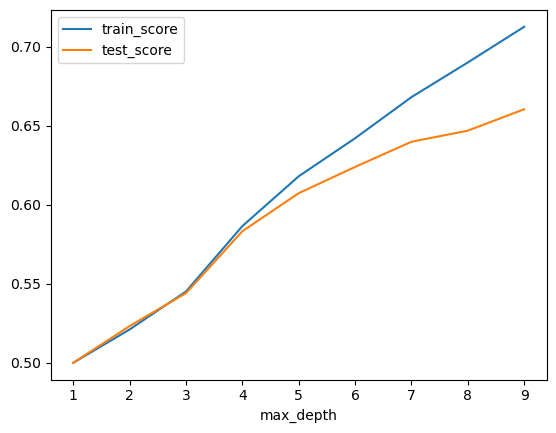

In [41]:
# Plot the results
models_df.plot()

In [257]:
param_grid = {
    'n_estimators': [100, 200, 400, 600, 800],
    'max_depth': [3,5,6,7,None],
    'min_samples_split': [2,4,6,8,10],
    'min_samples_leaf': [1,2,4,6,8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}


# Create the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=13)


#feature selection:
selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=13))
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = selector.transform(X_test)

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=100, cv=10, n_jobs=-1, verbose=3, random_state=13, scoring = 'balanced_accuracy')



# Fit the grid search to the data
random_search.fit(X_train_selected, y_train_resampled)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_selected)



Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': False}
Best Score: 0.8190560100299713


In [258]:
print(f'Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf)}')
print(classification_report(y_test, y_pred_rf))

print(f'Training Score: {best_rf.score(X_train_selected, y_train_resampled)}')
print(f'Testing Score: {best_rf.score(X_test_selected, y_test)}')

Balanced accuracy score: 0.7208689576719851
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      3774
           1       0.67      0.65      0.66      2456

    accuracy                           0.74      6230
   macro avg       0.72      0.72      0.72      6230
weighted avg       0.74      0.74      0.74      6230

Training Score: 0.9849394929776522
Testing Score: 0.7367576243980738


In [ ]:
#Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [4,5,6,7], # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at each leaf node
    'max_features': [None, 'sqrt', 'log2'],   # Number of features to consider when looking for the best split
    'bootstrap': [True, False]                  # Whether bootstrap samples are used when building trees
}

# Create the RandomForestClassifier model
rf_model_grid = RandomForestClassifier(random_state=13)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


In [ ]:
# Feature importance
best_rf = random_search.best_estimator_
importances = best_rf.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)


In [45]:
# Create the RandomForestClassifier model
rf_model_grid = RandomForestClassifier(random_state=13,
                                   n_estimators= 400,
                                    min_samples_split=6,
                                    min_samples_leaf= 1,
                                    max_features= None,
                                    max_depth=5,
                                    bootstrap=True,
                                    )

#fit the model
rf_model_grid.fit(X_train,y_train)

#predict
y_pred_rf_grid = rf_model_grid.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred_rf_grid))

0.6546975577800448


w/out problem id:
balanced accuracy score:0.627274261231916
w/ problem_id
balanced accuracy score: 0.6272031635966298

added month, year, day_of_week & oversampler: 0.7031507580583074  (max_depth = 7)
max_depth = 6: 0.6952886973963809
max_depth = 5: 0.6850869958864785
max_depth = 4: 0.666400940603374
max_depth = 6: 0.6783363886975691  (no sampler or problem id)

In [254]:
# Create the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=13,
                                   n_estimators= 400,
                                    min_samples_split=4,
                                    min_samples_leaf= 3,
                                    max_features=None,
                                    max_depth=6,
                                    bootstrap=True)

#fit the model
rf_model.fit(X_train_resampled,y_train_resampled)

#predict
y_pred_rf = rf_model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred_rf))

0.702255618331495


In [255]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf)}')
print(classification_report(y_pred_rf, y_test))

display(f'Training Score: {rf_model.score(X_train_resampled, y_train_resampled)}')
display(f'Testing Score: {rf_model.score(X_test, y_test)}')


'balanced accuracy score: 0.702255618331495'

              precision    recall  f1-score   support

           0       0.63      0.81      0.71      2937
           1       0.77      0.58      0.66      3293

    accuracy                           0.69      6230
   macro avg       0.70      0.69      0.69      6230
weighted avg       0.71      0.69      0.68      6230



'Training Score: 0.7307658334069429'

'Testing Score: 0.6871589085072232'

original: 
'balanced accuracy score: 0.625125364874359'
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      4790
           1       0.38      0.65      0.48      1440

    accuracy                           0.68      6230
   macro avg       0.63      0.67      0.62      6230
weighted avg       0.76      0.68      0.70      6230

'Training Score: 0.702857448630137''Testing Score: 0.6764044943820224'

added problem_id, month, year, day_of_week & oversampler max depth=7:
'balanced accuracy score: 0.702255618331495'
              precision    recall  f1-score   support

           0       0.63      0.81      0.71      2937
           1       0.77      0.58      0.66      3293

    accuracy                           0.69      6230
   macro avg       0.70      0.69      0.69      6230
weighted avg       0.71      0.69      0.68      6230

'Training Score: 0.7307658334069429''Testing Score: 0.6871589085072232'


In [46]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf_grid)}')
print(classification_report(y_pred_rf_grid, y_test))

display(f'Training Score: {rf_model_grid.score(X_train, y_train)}')
display(f'Testing Score: {rf_model_grid.score(X_test, y_test)}')


'balanced accuracy score: 0.6546975577800448'

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      4341
           1       0.49      0.64      0.55      1889

    accuracy                           0.69      6230
   macro avg       0.65      0.67      0.66      6230
weighted avg       0.72      0.69      0.70      6230



'Training Score: 0.7008775684931506'

'Testing Score: 0.6894060995184591'

original: 
'balanced accuracy score: 0.627274261231916'
              precision    recall  f1-score   support

           0       0.87      0.68      0.77      4791
           1       0.39      0.66      0.49      1439

    accuracy                           0.68      6230
   macro avg       0.63      0.67      0.63      6230
weighted avg       0.76      0.68      0.70      6230

'Training Score: 0.703392551369863'
'Testing Score: 0.6784911717495987'

added: month, year, day_of_week, no problem id &  no oversampled: max depth =6

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      4040
           1       0.57      0.64      0.60      2190

    accuracy                           0.70      6230
   macro avg       0.68      0.69      0.68      6230
weighted avg       0.71      0.70      0.71      6230
  Training Score: 0.7214790239726028'
  'Testing Score: 0.7017656500802568'

same: max_depth =5:
'balanced accuracy score: 0.6546975577800448'
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      4341
           1       0.49      0.64      0.55      1889

    accuracy                           0.69      6230
   macro avg       0.65      0.67      0.66      6230
weighted avg       0.72      0.69      0.70      6230

'Training Score: 0.7008775684931506'
'Testing Score: 0.6894060995184591'


